In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import sklearn
import spacy
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter

### Challenge 

**Directions:** For this challenge, you will need to choose a corpus of data from nltk or another source that includes categories you can predict and create an analysis pipeline that includes the following steps:

1. Data cleaning / processing / language parsing
2. Create features using two different NLP methods: For example, BoW vs tf-idf.
3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.
4. Assess your models using cross-validation and determine whether one model performed better.
5. Pick one of the models and try to increase accuracy by at least 5 percentage points.

<h1><center>Data Cleaning/Processing</center></h1>

In [2]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [3]:
hamlet = gutenberg.raw("shakespeare-hamlet.txt")
macbeth = gutenberg.raw("shakespeare-macbeth.txt")

In [4]:
hamlet[:100]

'[The Tragedie of Hamlet by William Shakespeare 1599]\n\n\nActus Primus. Scoena Prima.\n\nEnter Barnardo a'

In [5]:
def text_cleaner(text):
    text = re.sub(r"--", " ", text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = " ".join(text.split())
    return text

In [6]:
hamlet = text_cleaner(hamlet)

In [7]:
hamlet[:100]

"Actus Primus. Scoena Prima. Enter Barnardo and Francisco two Centinels. Barnardo. Who's there? Fran."

In [8]:
macbeth = text_cleaner(macbeth)

In [9]:
nlp = spacy.load("en")

hamlet_doc = nlp(hamlet)
macbeth_doc = nlp(macbeth)

In [10]:
hamlet_sents = [[sent, "Hamlet"] for sent in hamlet_doc.sents]
macbeth_sents = [[sent, "Macbeth"] for sent in macbeth_doc.sents]

hamlet_sents_df = pd.DataFrame(hamlet_sents)
macbeth_sents_df = pd.DataFrame(macbeth_sents)

sentences = pd.DataFrame(hamlet_sents + macbeth_sents)

In [11]:
sentences.tail()

,0,1
4941,"(So, thankes, to, all, at, once, ,, and, to, e...",Macbeth
4942,"(Flourish, .)",Macbeth
4943,"(Exeunt, Omnes, .)",Macbeth
4944,"(FINIS, .)",Macbeth
4945,"(THE, TRAGEDIE, OF, MACBETH, .)",Macbeth


Text(0,0.5,'Number of Sentences')

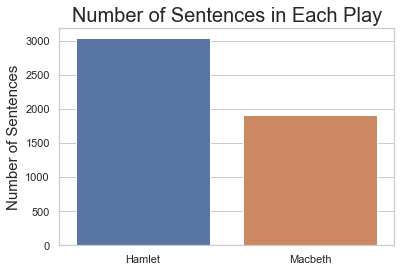

In [12]:
import seaborn as sns

sns.set(style="whitegrid")
ax = sns.barplot(x=sentences[1].unique(), y=sentences[1].value_counts(), data=sentences)

sns.set(rc={'figure.figsize':(10,10)})
ax.set_title("Number of Sentences in Each Play", size=20)
ax.set_ylabel("Number of Sentences", size=15)

<h1><center>Create Features Using Bag of Words</center></h1>

In [70]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
   

In [71]:
hamletwords = bag_of_words(hamlet_doc)

In [72]:
macbethwords = bag_of_words(macbeth_doc)

In [73]:
common_words = set(hamletwords + macbethwords)

In [74]:
abridged_sentences = sentences.sample(600)

In [75]:
abridged_sentences.shape

(600, 2)

In [76]:
abridged_sentences[1].value_counts()

Hamlet     388
Macbeth    212
Name: 1, dtype: int64

In [77]:
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [78]:
abridged_sentences.head()

,0,1
3423,"(Actus, Secundus, .)",Macbeth
688,"(no, ,, as, you, may, season, it, in, the, cha...",Hamlet
2322,"(Finding, our, selues, too, slow, of, Saile, ,...",Hamlet
3616,"(but, I, requited, him, for, his, Lye, ,, and)",Macbeth
1239,"(Rosin, .)",Hamlet


In [79]:
abridged_sentences = abridged_sentences.reset_index(drop=True)

In [80]:
abridged_sentences.head()

,0,1
0,"(Actus, Secundus, .)",Macbeth
1,"(no, ,, as, you, may, season, it, in, the, cha...",Hamlet
2,"(Finding, our, selues, too, slow, of, Saile, ,...",Hamlet
3,"(but, I, requited, him, for, his, Lye, ,, and)",Macbeth
4,"(Rosin, .)",Hamlet


In [81]:
word_counts = bow_features(abridged_sentences, common_words)

Processing row 0
Processing row 500


In [82]:
word_counts.head()

,howle,wassell,method,auspicious,adde,stop,vowe,tribute,bestil'd,banners,...,fitnesse,madnesse,malc,lesse,players,property,woe,lookes,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Actus, Secundus, .)",Macbeth
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(no, ,, as, you, may, season, it, in, the, cha...",Hamlet
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Finding, our, selues, too, slow, of, Saile, ,...",Hamlet
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(but, I, requited, him, for, his, Lye, ,, and)",Macbeth
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Rosin, .)",Hamlet


In [83]:
word_counts["text_source"].value_counts()


Hamlet     388
Macbeth    212
Name: text_source, dtype: int64

In [84]:
z = {"Hamlet": 1, "Macbeth": 0}

word_counts["text_source"] = word_counts["text_source"].map(z)

In [85]:
word_counts["text_source"].value_counts()


1    388
0    212
Name: text_source, dtype: int64

In [86]:
word_counts.head()

,howle,wassell,method,auspicious,adde,stop,vowe,tribute,bestil'd,banners,...,fitnesse,madnesse,malc,lesse,players,property,woe,lookes,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Actus, Secundus, .)",0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(no, ,, as, you, may, season, it, in, the, cha...",1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Finding, our, selues, too, slow, of, Saile, ,...",1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(but, I, requited, him, for, his, Lye, ,, and)",0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Rosin, .)",1


In [87]:
words = []
total = []

for word in word_counts.loc[:, ~word_counts.columns.isin(["text_sentence", "text_source"])].columns:
    words.append(word)
    total.append(sum(word_counts[word]))
    

In [88]:
total_word_counts = pd.DataFrame()
total_word_counts["word"] = words
total_word_counts["total"] = total
total_word_counts.head()

,word,total
0,howle,1
1,wassell,0
2,method,1
3,auspicious,0
4,adde,0


In [89]:
total_word_counts = total_word_counts[total_word_counts["total"] != 0]

In [90]:
total_word_counts = total_word_counts.sort_values("total", ascending=False)

Text(0.5,0,'Word')

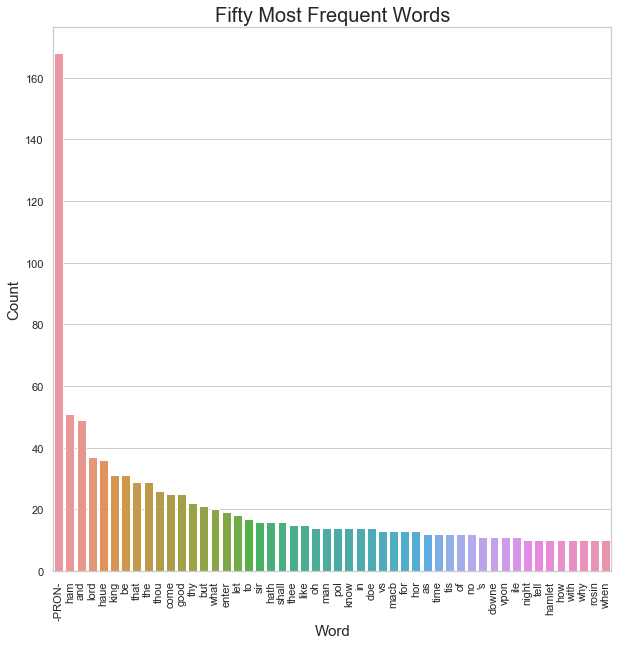

In [92]:
sns.set(style="whitegrid")
ax = sns.barplot(x=total_word_counts["word"][:50], y=total_word_counts["total"][:50], data=total_word_counts)
ax.set_xticklabels(total_word_counts["word"][:50], rotation=90)
ax.set_title("Fifty Most Frequent Words", size=20)
ax.set_ylabel("Count", size=15)
ax.set_xlabel("Word", size=15)



Text(0.5,0,'Word')

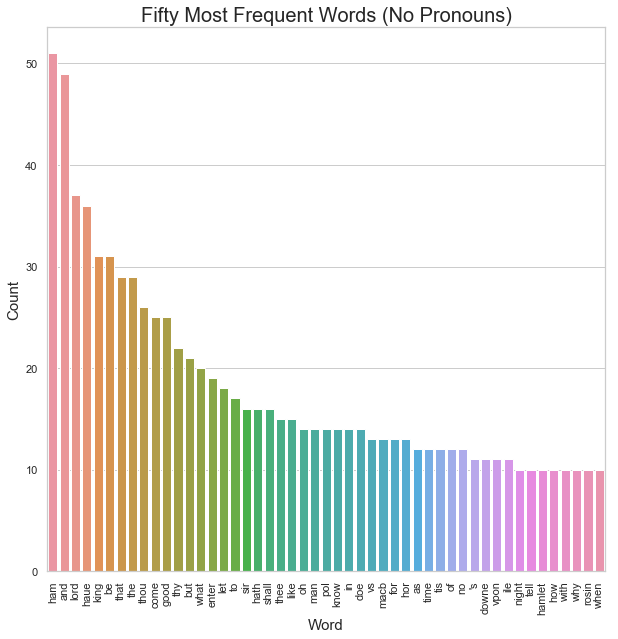

In [93]:
sns.set(style="whitegrid")
ax = sns.barplot(x=total_word_counts["word"][1:50], y=total_word_counts["total"][1:50], data=total_word_counts)
ax.set_xticklabels(total_word_counts["word"][1:50], rotation=90)
ax.set_title("Fifty Most Frequent Words (No Pronouns)", size=20)
ax.set_ylabel("Count", size=15)
ax.set_xlabel("Word", size=15)



<h1><center>Create Features Using TF-IDF</center></h1>

In [127]:
hamlet = gutenberg.sents("shakespeare-hamlet.txt")

In [128]:
macbeth = gutenberg.sents("shakespeare-macbeth.txt")

In [129]:
" ".join(hamlet[7])

'Nay answer me : Stand & vnfold your selfe'

In [130]:
shakespeare_sents = []

for sentence in hamlet:
    shakespeare_sents.append(" ".join(sentence))

print("Number of Hamlet sentences", len(shakespeare_sents))
    
for sentence in macbeth:
    shakespeare_sents.append(" ".join(sentence))
print("Total number of sentences:", len(shakespeare_sents))
    

Number of Hamlet sentences 3106
Total number of sentences: 5013


In [131]:
shakespeare_sents[7]

'Nay answer me : Stand & vnfold your selfe'

In [132]:
len(shakespeare_sents)

5013

In [133]:
shakespeare_sents[5000]

"Behold where stands Th ' Vsurpers cursed head : the time is free : I see thee compast with thy Kingdomes Pearle , That speake my salutation in their minds : Whose voyces I desire alowd with mine ."

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
vect_shakespeare_sents=vectorizer.fit_transform(shakespeare_sents)
print("Number of features: %d" % vect_shakespeare_sents.get_shape()[1])

Number of features: 2499


In [135]:
vect_shakespeare_sents_csr = vect_shakespeare_sents.tocsr()

n = vect_shakespeare_sents_csr.shape[0]

tfidf_bypara = [{} for _ in range(0,n)]

terms = vectorizer.get_feature_names()

for i, j in zip(*vect_shakespeare_sents_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = vect_shakespeare_sents_csr[i, j]

In [136]:
word_vectors = pd.DataFrame(tfidf_bypara)

word_vectors.head()

,abhorred,abide,aboord,aboue,abroad,absence,absent,absolute,absurd,abuse,...,yea,yeare,yeares,yeeld,yes,yesterday,yesty,yong,young,youth
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
shakespeare_sents[0:4]

['[ The Tragedie of Hamlet by William Shakespeare 1599 ]',
 'Actus Primus .',
 'Scoena Prima .',
 'Enter Barnardo and Francisco two Centinels .']

In [138]:
word_vectors["text_sentence"] = shakespeare_sents

word_vectors.head()

,abhorred,abide,aboord,aboue,abroad,absence,absent,absolute,absurd,abuse,...,yeare,yeares,yeeld,yes,yesterday,yesty,yong,young,youth,text_sentence
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[ The Tragedie of Hamlet by William Shakespear...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actus Primus .
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scoena Prima .
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enter Barnardo and Francisco two Centinels .
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Barnardo .


In [139]:
word_vectors.shape

(5013, 2500)

In [140]:
text_source = []
for i in range(0,3106):
    text_source.append("Hamlet")
for i in range(0,1907):
    text_source.append("Macbeth")
    
print(len(text_source))

5013


In [141]:
word_vectors["text_source"] = text_source

In [142]:
word_vectors.head()

,abhorred,abide,aboord,aboue,abroad,absence,absent,absolute,absurd,abuse,...,yeares,yeeld,yes,yesterday,yesty,yong,young,youth,text_sentence,text_source
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[ The Tragedie of Hamlet by William Shakespear...,Hamlet
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actus Primus .,Hamlet
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scoena Prima .,Hamlet
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enter Barnardo and Francisco two Centinels .,Hamlet
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Barnardo .,Hamlet


<h1><center>Fit Supervised Learning Models: Bag of Words Features</center></h1>

In [143]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier(n_estimators=10, max_depth=6)
Y = word_counts["text_source"]
X = np.array(word_counts.loc[:, ~word_counts.columns.isin(["text_sentence", "text source"])])



C:\Users\jesst\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [144]:
Y.shape

(600,)

In [145]:
X.shape

(600, 3109)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [147]:
rfc = rfc.fit(X_train, y_train)

print("Training set score:", rfc.score(X_train, y_train))
print("\nTest set score:", rfc.score(X_test, y_test))

Training set score: 0.6583333333333333

Test set score: 0.6625


In [148]:
rfc_predicted = rfc.predict(X_test)
pd.crosstab(y_test, rfc_predicted)

col_0,1
text_source,
0,81
1,159


In [149]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=.008)
lr = lr.fit(X_train, y_train)
print("Training set score:", lr.score(X_train, y_train))
print("\nTest set score:", lr.score(X_test, y_test))

Training set score: 0.65

Test set score: 0.6625


In [150]:
lr_predicted = lr.predict(X_test)
pd.crosstab(y_test, lr_predicted)

col_0,1
text_source,
0,81
1,159


<h1><center>Fit Supervised Learning Models: TF-IDF Features</center></h1>

In [151]:
to_num = {"Hamlet": 1, "Macbeth": 0}

word_vectors["text_source"] = word_vectors["text_source"].map(to_num)

In [152]:
word_vectors = word_vectors.fillna(0)

In [153]:

rfc = ensemble.RandomForestClassifier(n_estimators=10, max_depth=6)
Y = word_vectors["text_source"]
X = np.array(word_vectors.loc[:, ~word_vectors.columns.isin(["text_sentence", "text_source"])])



In [154]:
Y.shape

(5013,)

In [155]:
X.shape

(5013, 2499)

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [157]:
rfc_vect = rfc.fit(X_train, y_train)

print("Training set score:", rfc_vect.score(X_train, y_train))
print("\nTest set score:", rfc_vect.score(X_test, y_test))

Training set score: 0.6288659793814433

Test set score: 0.6266201395812563


In [158]:
rfc__vect_predicted = rfc_vect.predict(X_test)
pd.crosstab(y_test, rfc__vect_predicted)

col_0,0,1
text_source,,
0,16,749
1,0,1241


In [159]:
from sklearn.linear_model import LogisticRegression

lr_vect = LogisticRegression(C=.008)
lr_vect = lr.fit(X_train, y_train)
print("Training set score:", lr_vect.score(X_train, y_train))
print("\nTest set score:", lr_vect.score(X_test, y_test))

Training set score: 0.6202194878616561

Test set score: 0.6186440677966102


In [160]:
lr_vect_predicted = lr_vect.predict(X_test)
pd.crosstab(y_test, lr_vect_predicted)

col_0,1
text_source,
0,765
1,1241


<h1><center>Increasing Accuracy of Logistic Regression on Bag of Words Features</center></h1>

### Initial Results of Logistic Regression on Bag of Words Features

In [161]:
Y = word_counts["text_source"]
X = np.array(word_counts.loc[:, ~word_counts.columns.isin(["text_sentence", "text_source"])])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)


In [162]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=.008)
lr = lr.fit(X_train, y_train)
print("Training set score:", lr.score(X_train, y_train))
print("\nTest set score:", lr.score(X_test, y_test))

Training set score: 0.6361111111111111

Test set score: 0.6625


In [163]:
lr_predicted = lr.predict(X_test)
pd.crosstab(y_test, lr_predicted)

col_0,1
text_source,
0,81
1,159


### Feature Engineering and Parameter Manipulation to Improve Accuracy of Results by 5%

In [164]:
from sklearn.decomposition import PCA 

Y = word_counts["text_source"]
X = word_counts.loc[:, ~word_counts.columns.isin(["text_sentence", "text_source"])]

sklearn_pca = PCA(n_components=480)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [5.44124385e-02 2.30880844e-02 1.90107948e-02 1.69248777e-02
 1.63646465e-02 1.41858974e-02 1.37037574e-02 1.30390193e-02
 1.28704584e-02 1.25360499e-02 1.18044101e-02 1.14457379e-02
 1.05086949e-02 1.01087483e-02 9.67356103e-03 9.32533814e-03
 8.91363095e-03 8.84043328e-03 8.67907112e-03 8.48176997e-03
 8.32547878e-03 8.06320531e-03 7.89336137e-03 7.67277860e-03
 7.51450104e-03 7.29706919e-03 7.20237535e-03 7.13556726e-03
 6.88412072e-03 6.75437807e-03 6.70836179e-03 6.62228984e-03
 6.33158214e-03 6.23022370e-03 6.21482186e-03 6.10908065e-03
 6.03519281e-03 5.98281610e-03 5.88053767e-03 5.82885903e-03
 5.71817932e-03 5.59791962e-03 5.53637767e-03 5.46440338e-03
 5.29754611e-03 5.20781075e-03 5.12424391e-03 5.05625351e-03
 4.96153980e-03 4.85439139e-03 4.83507212e-03 4.80114244e-03
 4.73090685e-03 4.66903122e-03 4.61491322e-03 4.55841362e-03
 4.44026679e-03 4.40821906e-03 4.38983455e-03 4.218

In [165]:
sklearn_pca.explained_variance_ratio_.cumsum()

array([0.05441244, 0.07750052, 0.09651132, 0.1134362 , 0.12980084,
       0.14398674, 0.1576905 , 0.17072952, 0.18359997, 0.19613602,
       0.20794043, 0.21938617, 0.22989487, 0.24000362, 0.24967718,
       0.25900251, 0.26791615, 0.27675658, 0.28543565, 0.29391742,
       0.3022429 , 0.3103061 , 0.31819947, 0.32587224, 0.33338675,
       0.34068381, 0.34788619, 0.35502176, 0.36190588, 0.36866026,
       0.37536862, 0.38199091, 0.38832249, 0.39455271, 0.40076753,
       0.40687662, 0.41291181, 0.41889462, 0.42477516, 0.43060402,
       0.4363222 , 0.44192012, 0.4474565 , 0.4529209 , 0.45821845,
       0.46342626, 0.4685505 , 0.47360676, 0.4785683 , 0.48342269,
       0.48825776, 0.4930589 , 0.49778981, 0.50245884, 0.50707375,
       0.51163217, 0.51607243, 0.52048065, 0.52487049, 0.52908891,
       0.53324603, 0.53736422, 0.54146692, 0.54544722, 0.54939168,
       0.55332121, 0.55724034, 0.56109347, 0.56489754, 0.56866239,
       0.57239095, 0.57607593, 0.57973388, 0.58333828, 0.58691

In [166]:
X_with480_components = sklearn_pca.fit_transform(X)

In [167]:
X_with480_components.shape

(600, 480)

In [168]:
Y = word_counts["text_source"]
X = np.array(X_with480_components)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

lr = LogisticRegression(C=.008)
lr = lr.fit(X_train, y_train)
print("Training set score:", lr.score(X_train, y_train))
print("\nTest set score:", lr.score(X_test, y_test))

Training set score: 0.6361111111111111

Test set score: 0.6625


In [169]:
lr_predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [170]:
lr_predicted = lr.predict(X_test)
pd.crosstab(y_test, lr_predicted)

col_0,1
text_source,
0,81
1,159


In [171]:
word_counts_revised = word_counts

In [172]:
word_counts_revised.head()

,howle,wassell,method,auspicious,adde,stop,vowe,tribute,bestil'd,banners,...,fitnesse,madnesse,malc,lesse,players,property,woe,lookes,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Actus, Secundus, .)",0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(no, ,, as, you, may, season, it, in, the, cha...",1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Finding, our, selues, too, slow, of, Saile, ,...",1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(but, I, requited, him, for, his, Lye, ,, and)",0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Rosin, .)",1


In [174]:
list_stop = []
nlp = spacy.load("en")
for word in word_counts_revised.columns:
    loaded_word = nlp(word)
    if loaded_word[0].is_stop == True:
        list_stop.append(word)

In [175]:
len(list_stop)

118

In [176]:
word_counts_revised = word_counts_revised.drop(list_stop, axis=1)

In [177]:
word_counts_revised.head()

,howle,wassell,method,auspicious,adde,stop,vowe,tribute,bestil'd,banners,...,fitnesse,madnesse,malc,lesse,players,property,woe,lookes,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Actus, Secundus, .)",0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(no, ,, as, you, may, season, it, in, the, cha...",1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Finding, our, selues, too, slow, of, Saile, ,...",1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(but, I, requited, him, for, his, Lye, ,, and)",0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Rosin, .)",1


In [178]:
words = []
total = []

for word in word_counts_revised.loc[:, ~word_counts_revised.columns.isin(["text_sentence", "text_source"])].columns:
    words.append(word)
    total.append(sum(word_counts[word]))
    

In [179]:
len(words)

2990

In [180]:
total_word_counts_revised = pd.DataFrame()
total_word_counts_revised["word"] = words
total_word_counts_revised["total"] = total
total_word_counts_revised.head()

,word,total
0,howle,1
1,wassell,0
2,method,1
3,auspicious,0
4,adde,0


In [181]:
total_word_counts_revised = total_word_counts_revised[total_word_counts_revised["total"] != 0]

In [182]:
total_word_counts_revised = total_word_counts_revised.sort_values("total", ascending=False)

In [183]:
total_word_counts_revised.head()

,word,total
590,-PRON-,168
2032,ham,51
1861,lord,37
1481,haue,36
1142,king,31


Text(0.5,0,'Word')

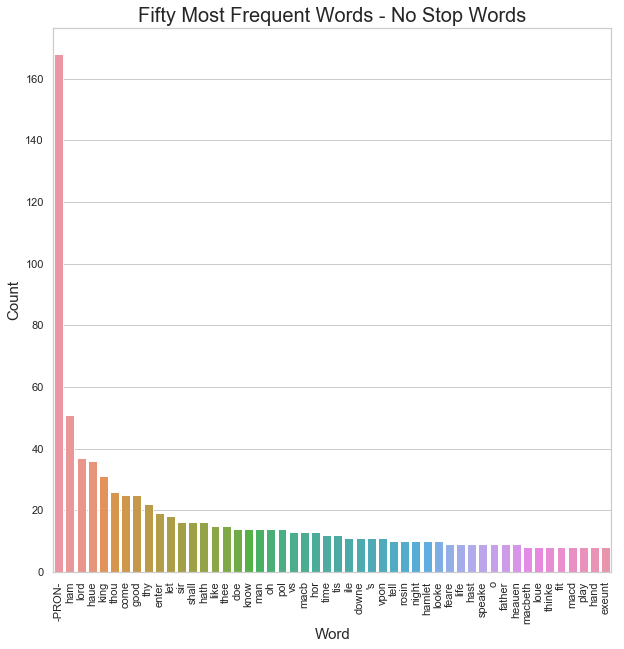

In [184]:
sns.set(style="whitegrid")
ax = sns.barplot(x=total_word_counts_revised["word"][:50], y=total_word_counts_revised["total"][:50], data=total_word_counts_revised)
ax.set_xticklabels(total_word_counts_revised["word"][:50], rotation=90)
ax.set_title("Fifty Most Frequent Words - No Stop Words", size=20)
ax.set_ylabel("Count", size=15)
ax.set_xlabel("Word", size=15)



Text(0.5,0,'Word')

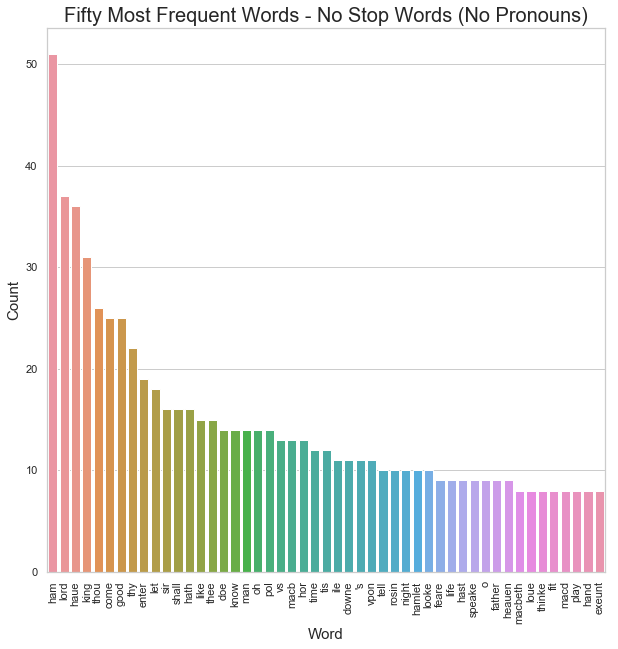

In [185]:
sns.set(style="whitegrid")
ax = sns.barplot(x=total_word_counts_revised["word"][1:50], y=total_word_counts_revised["total"][1:50], data=total_word_counts_revised)
ax.set_xticklabels(total_word_counts_revised["word"][1:50], rotation=90)
ax.set_title("Fifty Most Frequent Words - No Stop Words (No Pronouns)", size=20)
ax.set_ylabel("Count", size=15)
ax.set_xlabel("Word", size=15)



In [186]:
Y = word_counts_revised["text_source"]
X = np.array(word_counts_revised.loc[:, ~word_counts_revised.columns.isin(["text_sentence", "text_source"])])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)


In [187]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=.008)
lr = lr.fit(X_train, y_train)
print("Training set score:", lr.score(X_train, y_train))
print("\nTest set score:", lr.score(X_test, y_test))

Training set score: 0.6361111111111111

Test set score: 0.6625


In [188]:
lr_predicted = lr.predict(X_test)
pd.crosstab(y_test, lr_predicted)

col_0,1
text_source,
0,81
1,159
